In [0]:
######################################################################
#        Course Name: H6751 - Text & Web Mining                      # 
#   Group Assignment: Media Bias Detection                           #
#       Submitted by: Aye Chan Moe (G1901599F)                       #
#                     Lu Wei (G1901461A)                             # 
#                     Rajeshwer Sekaran (G1902060K)                  #                    
######################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
######################################################################
#   1. Loading data                                                  #                                     
######################################################################
df1 = pd.read_csv('articles1.csv')
df2 = pd.read_csv('articles2.csv')

dff = pd.concat([df1,df2])
dff = dff[['publication', 'content']]
dff.shape

(99999, 2)

In [0]:
######################################################################
#   2. Checking the list of publication                              #                                     
######################################################################
df = dff.sample(frac=1)
df['publication'].value_counts()

Breitbart              23781
New York Post          17493
CNN                    11488
New York Times          7803
Atlantic                7179
Business Insider        6757
National Review         6203
Talking Points Memo     5214
Guardian                4873
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [0]:
######################################################################
#   3. Filtering selected publications into new class array          #                                     
######################################################################
#Filtering Left:
n_s_a = df[df['publication'] == 'Atlantic']
n_s_t = df[df['publication'] == 'New York Times']

#Filtering Right:
n_s_b = df[df['publication'] == 'Breitbart']
n_s_p = df[df['publication'] == 'New York Post']
n_s = pd.concat([n_s_a,n_s_t,n_s_b,n_s_p])

In [0]:
######################################################################
#   4. Classifying and renaming publications                         #                                     
######################################################################
#Atlantic & New York Times given Left bias (0) and Breitbart & New York Posts given Right bias (1)
n_s['publication'] = [re.sub('Atlantic', '0', entry) for entry in n_s['publication']]
n_s['publication'] = [re.sub('New York Times', '0', entry) for entry in n_s['publication']]
n_s['publication'] = [re.sub('Breitbart', '1', entry) for entry in n_s['publication']]
n_s['publication'] = [re.sub('New York Post', '1', entry) for entry in n_s['publication']]

n_s = n_s.rename(columns={'publication': 'bias'})
n_s['bias'].value_counts()

1    41274
0    14982
Name: bias, dtype: int64

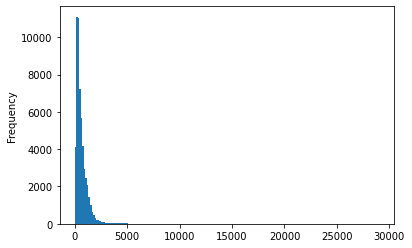

In [0]:
######################################################################
#   5. Data Preprocessing-1  for 'content' attribute                 #                                     
######################################################################
#Lower case, Replace publications and special charactor with empty space
text = n_s['content']
text= [word.replace('New York Post','') for word in text]
text = [word.replace('Breitbart','') for word in text]
text = [word.replace('New York Times','') for word in text]
text = [word.replace('Atlantic','') for word in text]
text = [words.lower() for words in text]
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
text = [REPLACE_BY_SPACE_RE.sub(' ', words)  for words in text]

s = n_s['content'].str.split().str.len()
s.plot.hist(bins=200)

In [0]:
######################################################################
#   6. Spliting dataset into train and test dataset                  #                                     
######################################################################
#train test split 90-10
train_X, test_X, train_Y, test_Y = train_test_split(text, n_s['bias'], test_size=0.10, random_state=1000)
#making label int
train_Y = train_Y.astype(int)
test_Y = test_Y.astype(int)

In [0]:
######################################################################
#   7. Generating baseline of accuracy score with Multiple Models    #                                     
######################################################################
#Count Vectorize
vectorizer = CountVectorizer()
vectorizer.fit(train_X)
X_train_new = vectorizer.transform(train_X)
X_test_new = vectorizer.transform(test_X)

#TFID transformer
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train_new)
X_test = tfidf_transformer.fit_transform(X_test_new)

In [0]:
#Logistic Regression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, train_Y)
score = lr_classifier.score(X_test, test_Y)
print(score)

0.9050835407038749


In [0]:
#Random Forest
rm_classifier = RandomForestClassifier()
rm_classifier.fit(X_train, train_Y)
score = rm_classifier.score(X_test, test_Y)
print(score)

0.853003910415926


In [0]:
#Extra Trees
et_classifier = ExtraTreesClassifier()
et_classifier.fit(X_train, train_Y)
score = et_classifier.score(X_test, test_Y)
print(score)

0.8460718094560967


In [0]:
#SVC
svc_classifier = SVC()
svc_classifier.fit(X_train, train_Y)
score = svc_classifier.score(X_test, test_Y)
print(score)

0.9200142196942765


In [0]:
#AdaBoost
ab_classifier = AdaBoostClassifier()
ab_classifier.fit(X_train, train_Y)
score = ab_classifier.score(X_test, test_Y)
print(score)

0.8608247422680413


In [0]:
######################################################################
#   8. Data Preprocessing-2  for 'content' attribute                 #                                     
######################################################################
#tokenize & convert to int sequence the content
tokenizer = Tokenizer()
tokenizer.fit_on_texts(n_s['content'])
X_train = tokenizer.texts_to_sequences(train_X)
X_test = tokenizer.texts_to_sequences(test_X)

vocab_size = len(tokenizer.word_index) + 1

max_len = 2000
embedding_dim = 50

#padding to make the input size consistent
X_train_final = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test_final = pad_sequences(X_test, padding='post', maxlen=max_len)
print(X_train_final)
print(train_Y)
print(vocab_size)

[[ 1390  3841  4470 ...     0     0     0]
 [14751    17    61 ...     0     0     0]
 [    4   744  1648 ...     0     0     0]
 ...
 [    1  6007     3 ...     0     0     0]
 [    7   320   266 ...     0     0     0]
 [  236   119    70 ...     0     0     0]]
26396    1
7640     0
23214    1
34167    1
32206    1
        ..
41423    1
3423     0
5863     0
1715     0
31400    1
Name: bias, Length: 50630, dtype: int64
278075


In [0]:
######################################################################
#   9. Creating DNN model                                            #                                     
######################################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
#Model design
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(40, activation='relu'))
model.add(Dropout(0.20))
model.add(layers.Dense(40, activation='relu'))
model.add(Dropout(0.20))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 50)          13903750  
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 40)                2040      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4

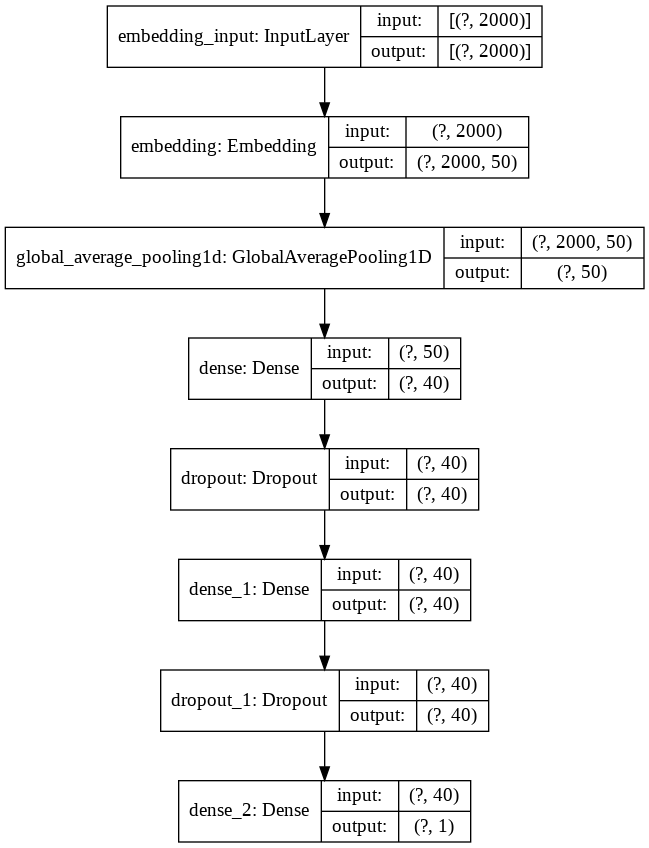

In [0]:
######################################################################
#   10. Displaying structure of layers in DNN model                  #                                     
######################################################################
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
######################################################################
#   11. Model fitting                                                #                                     
######################################################################
model_data = model.fit(X_train_final, train_Y, validation_split=0.20, epochs=3, batch_size=32)

Epoch 1/3
1266/1266 [==============================] - 189s 150ms/step - loss: 0.2633 - accuracy: 0.8924 - val_loss: 0.1120 - val_accuracy: 0.9595
Epoch 2/3
1266/1266 [==============================] - 191s 151ms/step - loss: 0.0737 - accuracy: 0.9750 - val_loss: 0.1233 - val_accuracy: 0.9580
Epoch 3/3
1266/1266 [==============================] - 190s 150ms/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.0987 - val_accuracy: 0.9651


In [0]:
######################################################################
#   12. Model prediction with scores                                 #                                     
######################################################################
#Test accuracy
score = model.evaluate(X_test_final, test_Y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09262587875127792
Test accuracy: 0.9681834578514099


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


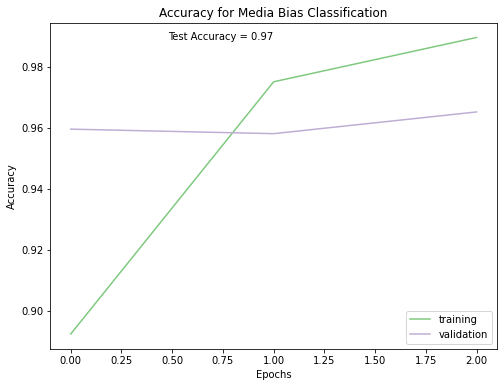

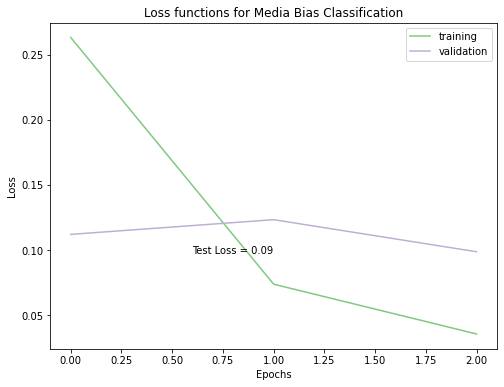

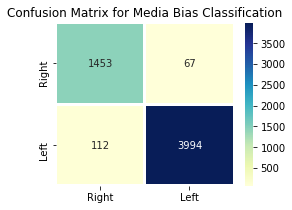

In [0]:
######################################################################
#   13. Visualization                                                #                                     
######################################################################
import seaborn as sns
from sklearn.metrics import confusion_matrix
 # Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(model_data.history['accuracy']))
    sns.lineplot(data=np.asarray(model_data.history['val_accuracy']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Bias Classification") 
    plt.legend(labels=['training', 'validation'],loc='lower right')
    plt.text(1,0.99,'Test Accuracy = ' + str(round(score[1],2)), horizontalalignment='right', verticalalignment='center') 
    plt.savefig('media_bias_acc.svg',format='png')

# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(model_data.history['loss']))
    sns.lineplot(data=np.asarray(model_data.history['val_loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Bias Classification") 
    plt.text(1, 0.1,'Test Loss = ' + str(round(score[0],2)), horizontalalignment='right', verticalalignment='center') 
    plt.legend(labels=['training', 'validation'])
    plt.savefig('media_bias_loss.svg',format='png')

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(test_Y,model.predict_classes(X_test_final)),\
annot=True,linewidths=2, cmap="YlGnBu",fmt="g",\
xticklabels=['Right','Left'],\
yticklabels=['Right','Left'])
plt.title("Confusion Matrix for Media Bias Classification") 
plt.autoscale()
plt.savefig('confusion_matrix_media_bias_bal.png',format='png',bbox_inches = "tight") 
